In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/keras-pretrained-imagenet-weights/resnet34_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/seresnet50_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/seresnet101_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/resnet18_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/densenet201_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/resnext50_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/vgg16_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/mobilenet_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/seresnet152_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/resnet101_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/seresnext101_imagenet_1000_no_top.h5
/kaggle/input/keras-pretrained-imagenet-weights/densenet169_imagenet_1000_no_top.h5
/kaggle/in

In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2

from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169, Xception, InceptionResNetV2, MobileNetV2, InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('seaborn')
%matplotlib inline


In [5]:
train_images='../input/plant-pathology-2021-fgvc8/train_images'
test_images='../input/plant-pathology-2021-fgvc8/test_images'
train_df=pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

In [6]:
train_df.head(10)

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
5,800edef467d27c15.jpg,healthy
6,800f85dc5f407aef.jpg,rust
7,801d6dcd96e48ebc.jpg,healthy
8,801f78399a44e7af.jpg,complex
9,8021b94d437eb7d3.jpg,healthy


In [7]:
train_df.isnull().sum()

image     0
labels    0
dtype: int64

In [8]:
train_df.columns 

Index(['image', 'labels'], dtype='object')

In [9]:
train_df['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

<AxesSubplot:xlabel='labels', ylabel='Count'>

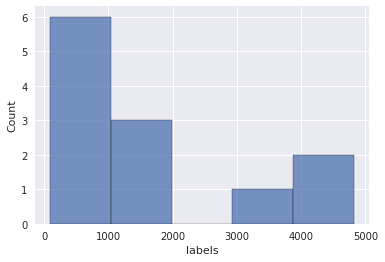

In [10]:
sns.histplot(train_df['labels'].value_counts(sort=True))

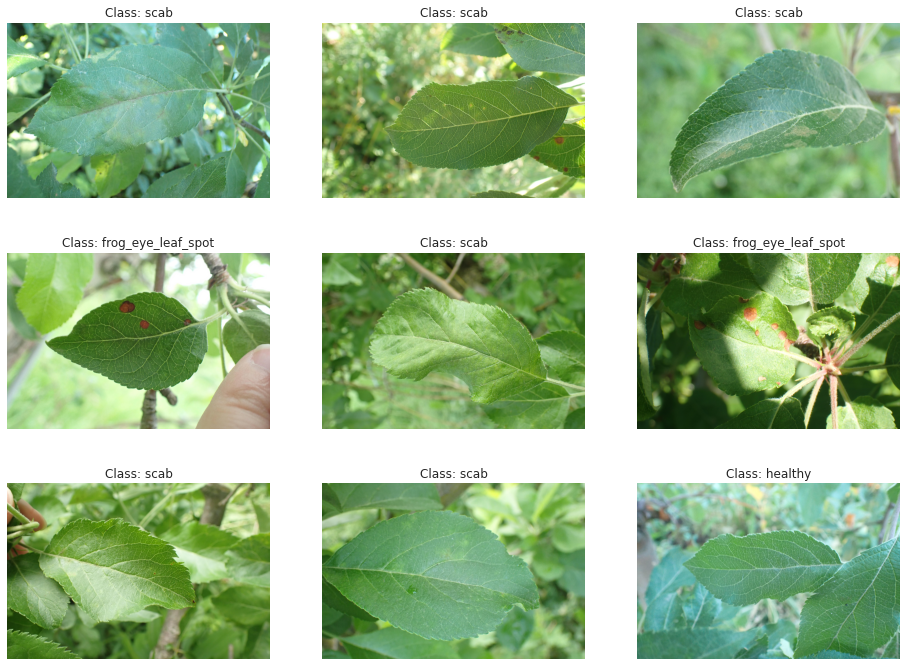

In [11]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()
ts = train_df.sample(9)
image_ids = ts["image"].values
labels = ts["labels"].values
visualize_batch(train_images,image_ids,labels)

In [12]:
train_df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [13]:
train_df['labels'] = train_df['labels'].apply(lambda x: tuple(x.split(" ")))
train_df.head()

,image,labels
0,800113bb65efe69e.jpg,"(healthy,)"
1,8002cb321f8bfcdf.jpg,"(scab, frog_eye_leaf_spot, complex)"
2,80070f7fb5e2ccaa.jpg,"(scab,)"
3,80077517781fb94f.jpg,"(scab,)"
4,800cbf0ff87721f8.jpg,"(complex,)"


In [14]:
datapath = glob('/kaggle/input/plant-pathology-2021-fgvc8/train_images/*')
print("Image Datasets Shape: ", len(datapath))

Image Datasets Shape:  18632


In [15]:
INPUT_SIZE = (256,256,3)
BATCH_SIZE = 32

In [16]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.07, 
    zoom_range= 0.1, 
    horizontal_flip = True,
    validation_split=0.2
)

In [17]:
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory="../input/plant-pathology-2021-fgvc8/train_images",
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2],
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    train_df,
    directory="../input/plant-pathology-2021-fgvc8/train_images",
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2],
    subset='validation'
)

Found 14906 validated image filenames belonging to 6 classes.
Found 3726 validated image filenames belonging to 6 classes.


In [18]:
train_generator.class_indices

{'complex': 0,
 'frog_eye_leaf_spot': 1,
 'healthy': 2,
 'powdery_mildew': 3,
 'rust': 4,
 'scab': 5}

In [19]:
for x, y in train_generator:
    break

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


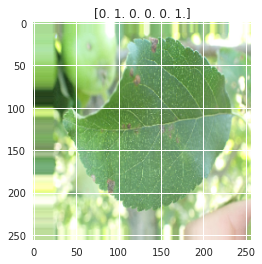

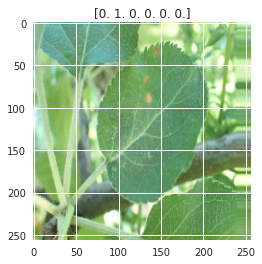

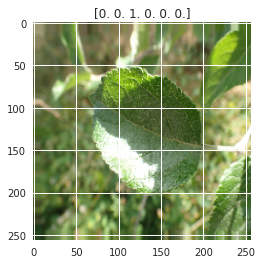

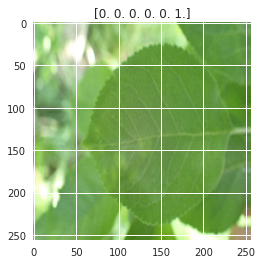

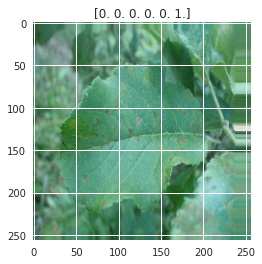

In [20]:
for i in range(5):
    plt.title(y[i])
    plt.imshow(x[i])
    plt.show()

In [21]:
weights_path = "../input/keras-pretrained-imagenet-weights/inceptionv3_imagenet_1000_no_top.h5"

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


In [23]:
pre_model = InceptionV3(include_top=False, weights=weights_path, input_shape=INPUT_SIZE)

In [24]:
model = Sequential()
model.add(pre_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9437312   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 31,240,870
Trainable params: 31,206,438
Non-trainable params: 34,432
_________________________________________________________________


In [26]:
callback= ReduceLROnPlateau(monitor='val_loss',
                       factor=.01, 
                       patience=3, 
                       min_lr=1e-5) 

In [27]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [28]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator)//BATCH_SIZE,
    epochs=4,
    validation_data=val_generator,
    validation_steps=len(val_generator)//BATCH_SIZE
)

Epoch 1/4
14/14 [==============================] - 113s 7s/step - loss: 2.4404 - accuracy: 0.2464 - val_loss: 1.9735 - val_accuracy: 0.3333
Epoch 2/4
14/14 [==============================] - 98s 7s/step - loss: 2.0196 - accuracy: 0.2910 - val_loss: 1.6428 - val_accuracy: 0.4479
Epoch 3/4
14/14 [==============================] - 97s 7s/step - loss: 1.5878 - accuracy: 0.4466 - val_loss: 1.5354 - val_accuracy: 0.4271
Epoch 4/4
14/14 [==============================] - 97s 7s/step - loss: 1.4935 - accuracy: 0.4850 - val_loss: 1.6891 - val_accuracy: 0.4375


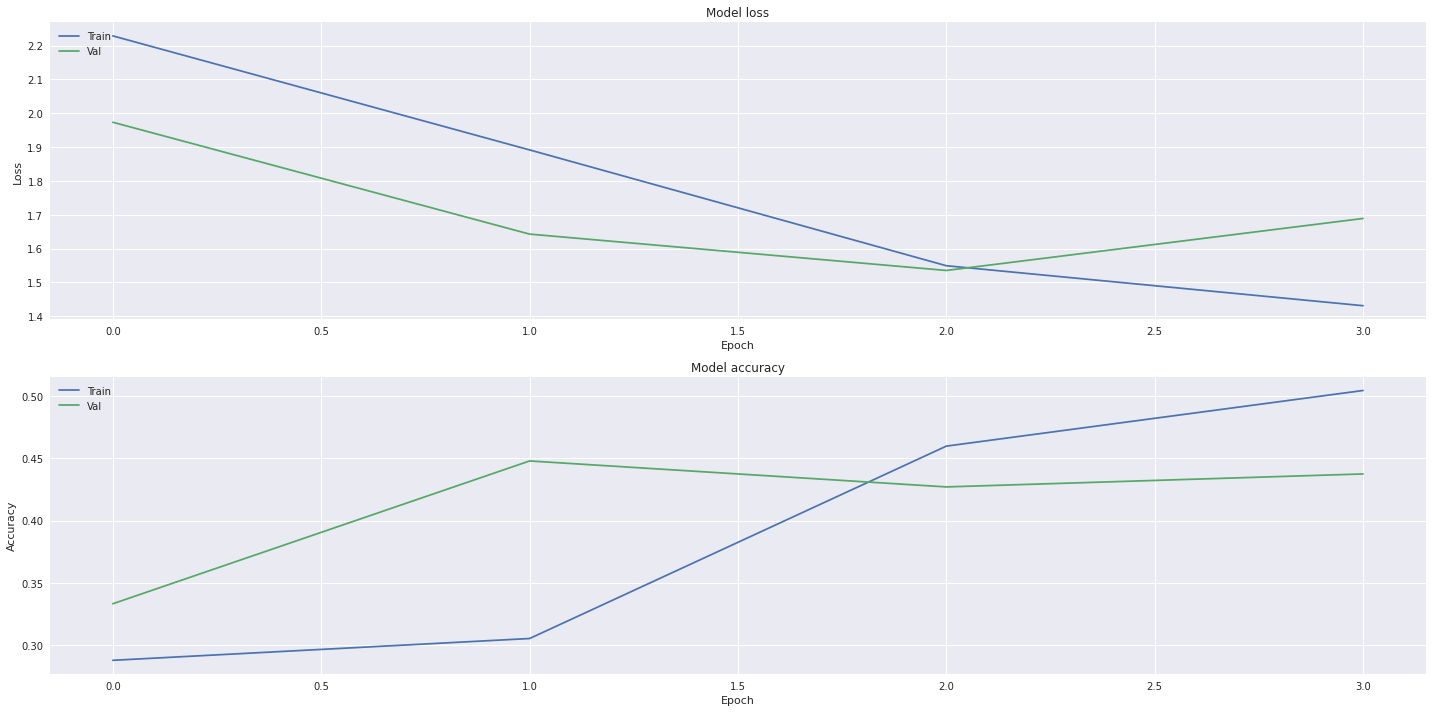

In [29]:
f,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='upper left')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='upper left')

f.tight_layout()
plt.show()

In [30]:
submission = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_generator =  test_datagen.flow_from_dataframe(
    submission,
    directory="../input/plant-pathology-2021-fgvc8/test_images",
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=INPUT_SIZE[:2]
)


Found 3 validated image filenames.


In [32]:
train_generator.class_indices.items()

dict_items([('complex', 0), ('frog_eye_leaf_spot', 1), ('healthy', 2), ('powdery_mildew', 3), ('rust', 4), ('scab', 5)])

In [ ]:
def get_key(val):
    for key, value in train_generator.class_indices.items():
        if val == value:
            return key

In [ ]:
preds = model.predict(test_generator)
print(preds)


In [ ]:
def get_preds_to_labels(preds):
    pred_lists = []
    for pred in preds:
        pred_list = []
        health = (pred>=0.4)
        
        # get healthy
        if health.sum()==0:
            label = 'healthy'
            pred_list.append(label)
            
        elif pred[2]>=0.5:
            label = 'healthy'
            pred_list.append(label)
            
        # get eles label
        else:
            for j, sub in enumerate(pred):
                if sub>=0.28:
                    label = get_key(j)
                    pred_list.append(label)
                               
        pred_lists.append(' '.join(pred_list))
    return pred_lists

In [ ]:
preds_list = get_preds_to_labels(preds)

In [ ]:
submission['labels'] = preds_list
submission.head()